### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1) Initialize Model

In [2]:
#------------------------- Set Model Parameters
model, steps = get_model_for_problem_formulation(7)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 4000

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [3]:
#'''

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 7) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1,]*len(model.outcomes),
                                            convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/MORDM1.csv')

#'''

[MainProcess/INFO] pool started with 7 workers
1078it [01:17, 13.88it/s]                                                      
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [4]:
# final result data set
results = pd.read_csv("results/MORDM1.csv")
results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,Total Investment Costs
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.322761e+06


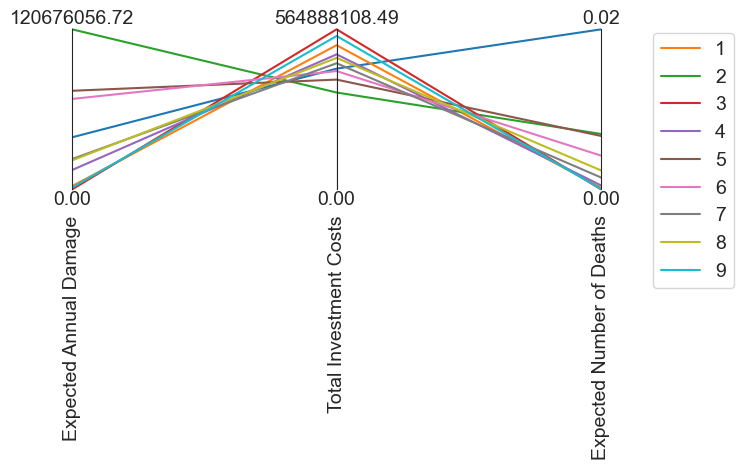

In [29]:
from ema_workbench.analysis import parcoords

colors = sns.color_palette()

data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
    paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])

paraxes.legend()
plt.show()

### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [30]:
# constrain conditions
constraint = results['Expected Annual Damage'] > 100000000
print ("no. of removed: ", np.sum(constraint))
print ("removed entries: ")
results[constraint]

no. of removed:  1
removed entries: 


,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
2,2,0,0,0,0,0,0,0,0,0,...,4,0,0,8,6,3,4,1.206761e+08,3.419144e+08,0.006067


In [31]:
# reduced dataframe of candidate solutions
new_results = results1[np.invert(constraint)]
print ("new results:")
new_results

new results:


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,0,1,0,0,0,0,0,1,0,0,...,5,6,6,4,6,0,2,3.927985e+07,4.261646e+08,0.017520
1,0,0,0,0,0,0,1,0,0,0,...,0,3,2,6,6,6,3,2.480472e+06,5.089992e+08,0.000161
3,0,0,0,0,0,0,0,0,0,0,...,7,5,3,6,6,7,7,0.000000e+00,5.648881e+08,0.000000
4,0,0,0,0,0,0,1,0,0,0,...,4,0,5,9,5,1,0,1.460931e+07,4.766259e+08,0.000431
5,0,0,0,0,0,0,1,0,0,0,...,7,0,3,8,4,4,0,7.435158e+07,3.875578e+08,0.005850
6,0,0,0,0,0,0,1,0,0,0,...,4,3,0,6,6,7,2,6.821306e+07,4.175949e+08,0.003695
7,0,0,0,0,0,0,1,0,0,0,...,6,0,4,9,4,1,1,2.291788e+07,4.451712e+08,0.001298
8,0,0,0,0,0,0,0,0,0,0,...,1,6,0,8,6,3,0,2.188055e+07,4.641036e+08,0.002075
9,0,1,0,0,0,0,0,0,0,0,...,0,2,2,1,6,0,1,1.361430e+06,5.415225e+08,0.000044


In [32]:
# place candidate solutions into format

policies = new_results.drop([o.name for o in model.outcomes], axis=1)

from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows(): #i is policy no
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

policies_to_evaluate

[Policy({'0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 1, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 1, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 4, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 6, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 5, 'A.4_DikeIncrease 0': 6, 'A.4_DikeIncrease 1': 6, 'A.4_DikeIncrease 2': 4, 'A.5_DikeIncrease 0': 6, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 2}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 2, 'A.1_DikeIncrease 1': 6, 'A.1_DikeIncrease 2': 2, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

#### 3b Robustness Analysis (Run Scenarios)

In [33]:
'''

n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2.tar.gz')

'''

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 9 policies * 1 model(s) = 900 experiments
100%|████████████████████████████████████████| 900/900 [04:44<00:00,  3.16it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [38]:
rob_results = load_results ('results/MORDM2.tar.gz')

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final assignment\results\MORDM2.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [39]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [40]:
experiments, outcomes = rob_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,1.674827e+17,2.540139e+01,0.074380
1,5.113118e+16,2.273073e+12,0.000640
3,1.220517e+17,3.204631e+12,0.000750
4,6.046720e+15,1.387078e+12,0.000051
5,7.119939e+16,4.138667e+12,0.001279
6,5.546707e+16,5.228207e+12,0.000676
7,1.569454e+16,2.763330e+12,0.000315
8,2.441684e+17,6.154787e+12,0.002618
9,1.415494e+17,3.527467e+12,0.000805


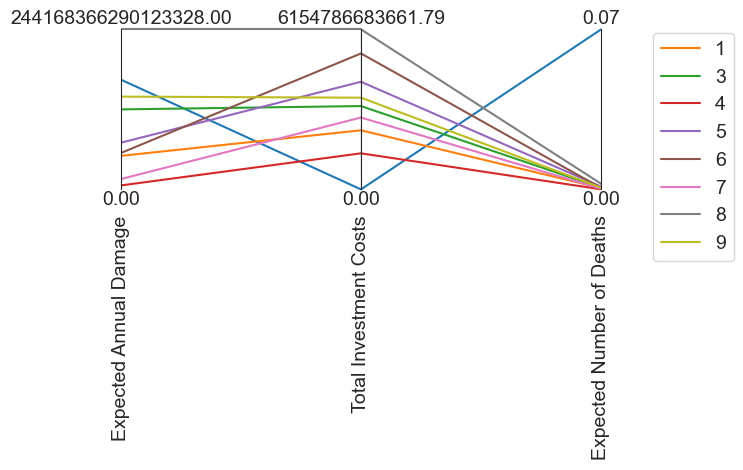

In [42]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
    paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])

paraxes.legend()

#paraxes.invert_axis('max_P')
plt.show()

##### 3c2 Calculate Regret

In [43]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [45]:
experiments, outcomes = rob_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\ryant\AppData\Local\Temp\ipykernel_8232\1623575980.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


visualize as heatmap

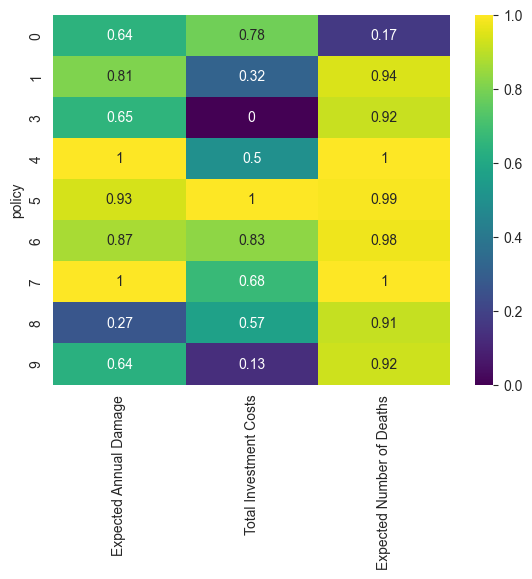

In [46]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

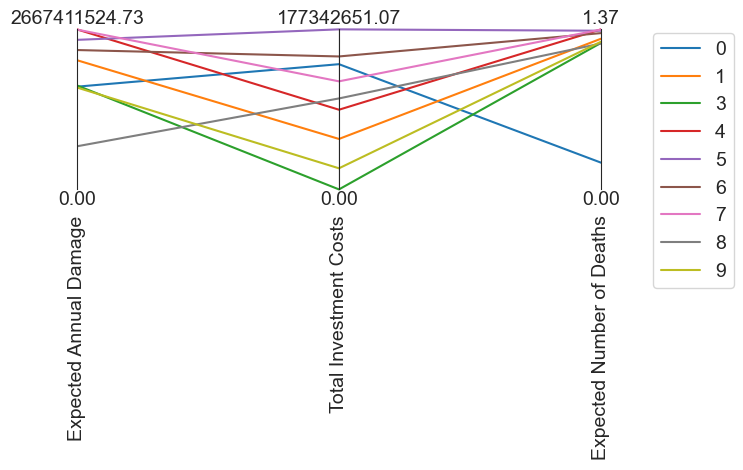

In [48]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

##### 3c3 Scenario Discovery for some conditions (IF NECESSARY)

In [51]:
'''

from ema_workbench.analysis import prim

x = 
y = 

prim_alg = prim.Prim(x, y, threshold=0.5)
box = prim_alg.find_box()

'''

NameError: name 'outcome_names' is not defined

In [ ]:
#box.inspect_tradeoff()

In [ ]:
#boxno = 2
#box.inspect(boxno)

In [ ]:
#box.select(boxno)